## Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

## Load the Dataset

In [2]:
df = pd.read_csv('Data\AIDA_Results_IA_Institut.csv')
df.head()

,Start,Diver,Gender,Discipline,Line,Official Top,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event
0,1,Tasos Grillakis (GRC),M,FIM,NaN,00:00,33,23 m,YELLOW,12.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
1,2,Antonis Papantonatos (GRC),M,FIM,NaN,00:00,55,47 m,YELLOW,38.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
2,3,Dimitris Koumoulos (GRC),M,CNF,NaN,00:00,55,55 m,WHITE,55.0,-,Depth Event 2016,Depth Competition,2016-07-17,other
3,4,Christos Papadopoulos (GRC),M,CWT,NaN,00:00,55,55 m,WHITE,55.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other
4,5,Anna Chalari (GRC),F,CWT,NaN,00:00,15,15 m,WHITE,15.0,OK,Depth Event 2016,Depth Competition,2016-07-17,other


## Data Preprocessing & Feature Engineering

In [3]:
# Romove duplicates
df = df.drop_duplicates()

In [4]:
# Supposons que df est votre DataFrame et 'Diver' est la colonne à diviser
df[['Name', 'Country']] = df['Diver'].str.rsplit(' ', n=1, expand=True).astype(str)

# Extraire et supprimer les parenthèses des valeurs de la colonne 'Country'
df['Country'] = df['Country'].str.strip('()')


In [5]:
df['RP'] = df['RP'].apply(lambda x: x.split(' ')[0] if x != '-' else None).astype(float)

In [6]:
df['Points'] = df['Points'].replace('-', None).astype(float)

In [7]:
df['Remarks'] = df['Remarks'].str.upper()

In [8]:
# Dropping irrelevant columns
#df.drop(['Start', 'Line', 'Official Top'], axis=1, inplace=True)

In [9]:

df['Depth_Difference'] = df['AP'] - df['RP']



In [10]:
# Create the 'Month' column by extracting the month name
df['Day'] = pd.to_datetime(df['Day'])
df['Month'] = df['Day'].dt.month_name().astype(str)

In [11]:
# Convert to datetime if not already
df['Day'] = pd.to_datetime(df['Day'])

# Format dates as 'Day Month Year'
df['Day'] = df['Day'].dt.strftime('%d %B %Y').astype(str)

In [12]:
df.head()

,Start,Diver,Gender,Discipline,Line,Official Top,AP,RP,Card,Points,Remarks,Title Event,Event Type,Day,Category Event,Name,Country,Depth_Difference,Month
0,1,Tasos Grillakis (GRC),M,FIM,NaN,00:00,33,23.0,YELLOW,12.0,-,Depth Event 2016,Depth Competition,17 July 2016,other,Tasos Grillakis,GRC,10.0,July
1,2,Antonis Papantonatos (GRC),M,FIM,NaN,00:00,55,47.0,YELLOW,38.0,-,Depth Event 2016,Depth Competition,17 July 2016,other,Antonis Papantonatos,GRC,8.0,July
2,3,Dimitris Koumoulos (GRC),M,CNF,NaN,00:00,55,55.0,WHITE,55.0,-,Depth Event 2016,Depth Competition,17 July 2016,other,Dimitris Koumoulos,GRC,0.0,July
3,4,Christos Papadopoulos (GRC),M,CWT,NaN,00:00,55,55.0,WHITE,55.0,OK,Depth Event 2016,Depth Competition,17 July 2016,other,Christos Papadopoulos,GRC,0.0,July
4,5,Anna Chalari (GRC),F,CWT,NaN,00:00,15,15.0,WHITE,15.0,OK,Depth Event 2016,Depth Competition,17 July 2016,other,Anna Chalari,GRC,0.0,July


In [13]:
# Create 'experience dive' feature
df.sort_values(by=['Diver', 'Day'], inplace=True)
df['experience_dive'] = df.groupby('Diver').cumcount()

# Create 'experience discipline' feature
df['experience_discipline'] = df.groupby(['Diver', 'Discipline']).cumcount()


## Exploratory Data Analysis (EDA)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26841 entries, 13306 to 26685
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Start                  26841 non-null  int64  
 1   Diver                  26841 non-null  object 
 2   Gender                 26841 non-null  object 
 3   Discipline             26841 non-null  object 
 4   Line                   4694 non-null   float64
 5   Official Top           26841 non-null  object 
 6   AP                     26841 non-null  int64  
 7   RP                     26703 non-null  float64
 8   Card                   26841 non-null  object 
 9   Points                 26703 non-null  float64
 10  Remarks                26836 non-null  object 
 11  Title Event            26841 non-null  object 
 12  Event Type             26841 non-null  object 
 13  Day                    26841 non-null  object 
 14  Category Event         26841 non-null  object 
 15  Nam

In [15]:
df.describe()

,Start,Line,AP,RP,Points,Depth_Difference,experience_dive,experience_discipline
count,26841.000000,4694.000000,26841.000000,26703.000000,26703.000000,26703.000000,26841.000000,26841.000000
mean,31.253344,1.058585,53.343579,50.429502,43.930397,2.851365,10.174956,4.060579
std,66.547885,0.234872,23.579628,23.555622,26.697673,13.604107,15.599670,7.233336
min,1.000000,1.000000,-1.000000,-2.000000,-99.000000,-107.000000,0.000000,0.000000
25%,6.000000,1.000000,38.000000,35.000000,28.000000,0.000000,1.000000,0.000000
50%,13.000000,1.000000,51.000000,50.000000,45.000000,0.000000,4.000000,1.000000
75%,28.000000,1.000000,69.000000,65.000000,61.000000,0.000000,13.000000,5.000000
max,708.000000,2.000000,130.000000,138.000000,130.000000,130.000000,138.000000,95.000000


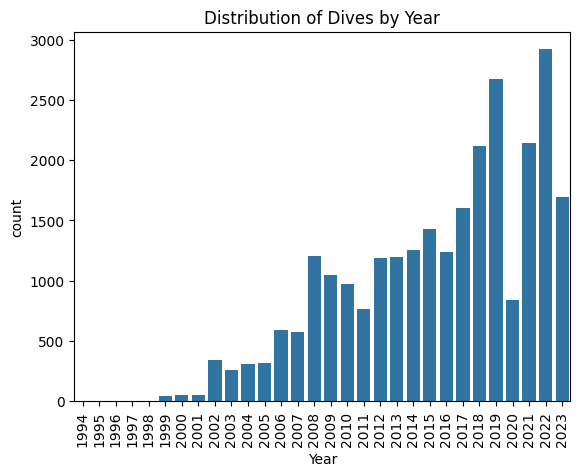

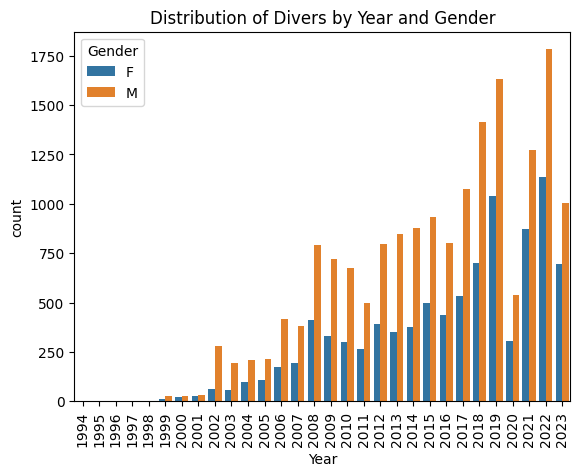

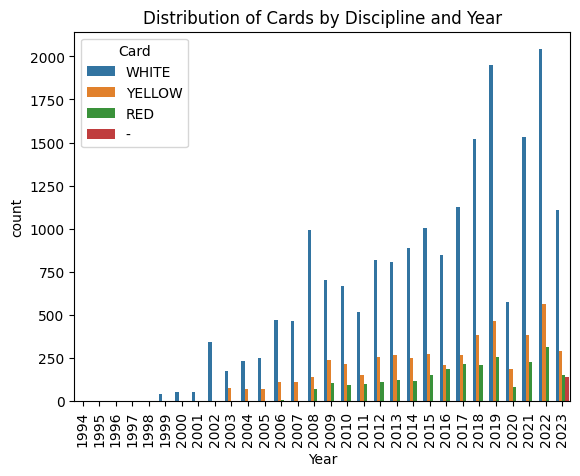

In [16]:
# Distribution of dives by year
df['Day'] = pd.to_datetime(df['Day'])
df['Year'] = df['Day'].dt.year
sns.countplot(x='Year', data=df)
plt.title('Distribution of Dives by Year')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()

# Distribution of divers by year and gender
sns.countplot(x='Year', hue='Gender', data=df)
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.title('Distribution of Divers by Year and Gender')
plt.show()

# Distribution of cards by discipline and year
sns.countplot(x='Year', hue='Card', data=df)
plt.title('Distribution of Cards by Discipline and Year')
plt.xticks(rotation=90)  # Rotate x-axis labels
plt.show()


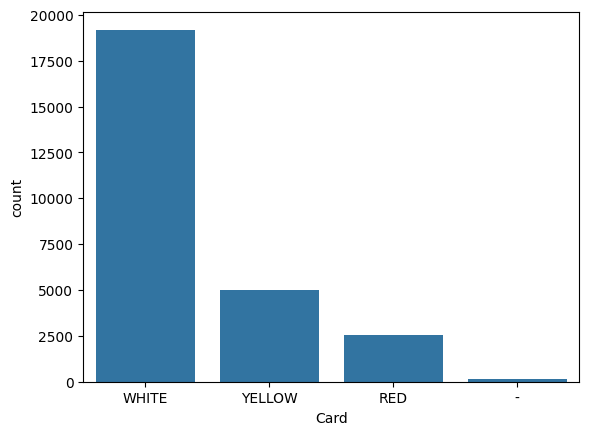

In [17]:
# Plotting distribution of a variable
sns.countplot(x='Card', data=df)
plt.show()

## Preparing Data for Machine Learning

In [18]:
# For numerical columns
df['AP'] = df['AP'].fillna(df['AP'].mean())
df['RP'] = df['RP'].fillna(df['RP'].mean())

# For categorical columns, you can replace with mode or a specific category
df['Discipline'] = df['Discipline'].fillna(df['Discipline'].mode()[0])



## Building a Machine Learning Model

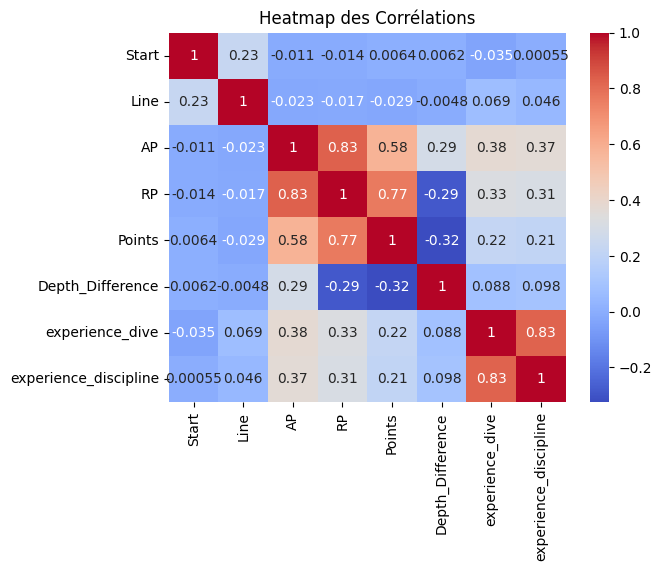

In [19]:

# Codage One-Hot pour les variables catégorielles
df_encoded = pd.get_dummies(df, columns=['Discipline'])

# Sélectionner uniquement les colonnes numériques pour la corrélation
numeric_cols = df_encoded.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_encoded[numeric_cols].corr()

# Créer la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap des Corrélations')
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Séparer les caractéristiques et la cible
X = df.drop('Card', axis=1)
y = df['Card']

# Codage One-Hot pour les variables catégorielles et normalisation pour les numériques
categorical_features = ['Diver', 'Gender', 'Discipline', 'Title Event', 'Event Type']
numeric_features = ['AP', 'RP', 'Points', 'Day']

# Prétraitement pour les pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
import pandas as pd

# Load your data
# Replace this with the path to your dataset
data = pd.read_csv('Data\AIDA_Results_IA_Institut.csv')

# Transform categorical data into numerical
# For 'Discipline' column
disciplines = {'CNF': 1, 'FIM': 2, 'CWT': 3, 'CWT-B': 4}
data['Discipline'] = data['Discipline'].map(disciplines)

# For 'Gender' column
genders = {'H': 1, 'F': 2}
data['Gender'] = data['Gender'].map(genders)

# Remove rows with other categories in 'Discipline' and 'Gender'
data = data[data['Discipline'].notnull() & data['Gender'].notnull()]

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Day'])

# Supposons que df est votre DataFrame et 'Diver' est la colonne à diviser
data[['Name', 'Country']] = df['Diver'].str.rsplit(' ', n=1, expand=True).astype(str)

# Extraire et supprimer les parenthèses des valeurs de la colonne 'Country'
data['Country'] = df['Country'].str.strip('()')

# Extract month from 'Date' column
data['Month'] = data['Date'].dt.month

# Calculate cumulative number of dives per athlete (experience dive)
data = data.sort_values(by=['Name', 'Date'])
data['Experience Dive'] = data.groupby('Name').cumcount() + 1

# Calculate cumulative number of dives per athlete per discipline (experience discipline)
data['Experience Discipline'] = data.groupby(['Name', 'Discipline']).cumcount() + 1

# (Bonus) Feel free to create additional numerical features here

# Save the processed data to a new CSV file
data.to_csv('processed_dataset.csv', index=False)

print(data.head())


       Start Diver  Gender  Discipline  Line Official Top  AP    RP    Card  \
13306    136    ()     2.0         3.0   NaN        00:00   0  37 m   WHITE   
13343    140    ()     2.0         3.0   NaN        00:00   0  40 m   WHITE   
11224     10    ()     2.0         3.0   NaN        00:00   0  31 m   WHITE   
2639     162    ()     2.0         3.0   NaN        00:00   0  33 m   WHITE   
8973     137    ()     2.0         3.0   NaN        00:00  34  32 m  YELLOW   

      Points  ...                             Title Event         Event Type  \
13306   37.0  ...         Compiled rankings for year 2000        Competition   
13343   40.0  ...         Compiled rankings for year 2001        Competition   
11224   31.0  ...  1st Portuguese Freediving Championship        Competition   
2639    33.0  ...                   AIDA Pacific Cup 2002  Mixed Competition   
8973    12.0  ...        Sony Freediver Open Classic 2003  Mixed Competition   

              Day Category Event       Date 

In [24]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Assuming 'Card' is the column indicating if a red card was given
# Filter the dataset to include only dives where a red card was given
red_card_data = data[data['Card'] == 'RED']

# Selecting relevant features for clustering
# Replace these with the actual column names
features = ['Discipline', 'Experience Dive', 'Experience Discipline']
X = red_card_data[features]

# Creating a pipeline for scaling and clustering
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=0))
])

# Fit the pipeline to the data
pipeline.fit(X)

# Adding the cluster labels to the dataset
red_card_data['Cluster'] = pipeline['kmeans'].labels_

# Save the clustered data
red_card_data.to_csv('red_card_clustering.csv', index=False)

# To analyze the clusters
for cluster in sorted(red_card_data['Cluster'].unique()):
    cluster_data = red_card_data[red_card_data['Cluster'] == cluster]
    print(f'Cluster {cluster}:')
    print(cluster_data.describe())

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Temp\ipykernel_2476\373539071.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_card_data['Cluster'] = pipeline['kmeans'].labels_


Cluster 0:
            Start  Gender  Discipline       Line          AP  \
count  102.000000   102.0  102.000000  16.000000  102.000000   
mean    27.156863     2.0    2.411765   1.125000   74.049020   
min      1.000000     2.0    1.000000   1.000000   44.000000   
25%      8.250000     2.0    2.000000   1.000000   58.000000   
50%     17.000000     2.0    3.000000   1.000000   73.000000   
75%     26.750000     2.0    3.000000   1.000000   90.000000   
max    289.000000     2.0    3.000000   2.000000  123.000000   
std     39.357902     0.0    0.812683   0.341565   19.193841   

                                Date       Month  Experience Dive  \
count                            102  102.000000       102.000000   
mean   2017-02-23 21:38:49.411764736    7.176471        37.970588   
min              2009-04-03 00:00:00    3.000000        16.000000   
25%              2015-04-27 00:00:00    5.000000        28.250000   
50%              2016-06-15 00:00:00    7.000000        36.500000  

In [25]:
# Analyzing each cluster
for cluster in sorted(red_card_data['Cluster'].unique()):
    cluster_data = red_card_data[red_card_data['Cluster'] == cluster]
    print(f'\nCluster {cluster} Analysis:')
    print(cluster_data[features].mean())


Cluster 0 Analysis:
Discipline                2.411765
Experience Dive          37.970588
Experience Discipline    19.156863
dtype: float64

Cluster 1 Analysis:
Discipline               2.551320
Experience Dive          7.067449
Experience Discipline    3.853372
dtype: float64

Cluster 2 Analysis:
Discipline                1.000000
Experience Dive          10.426396
Experience Discipline     3.969543
dtype: float64


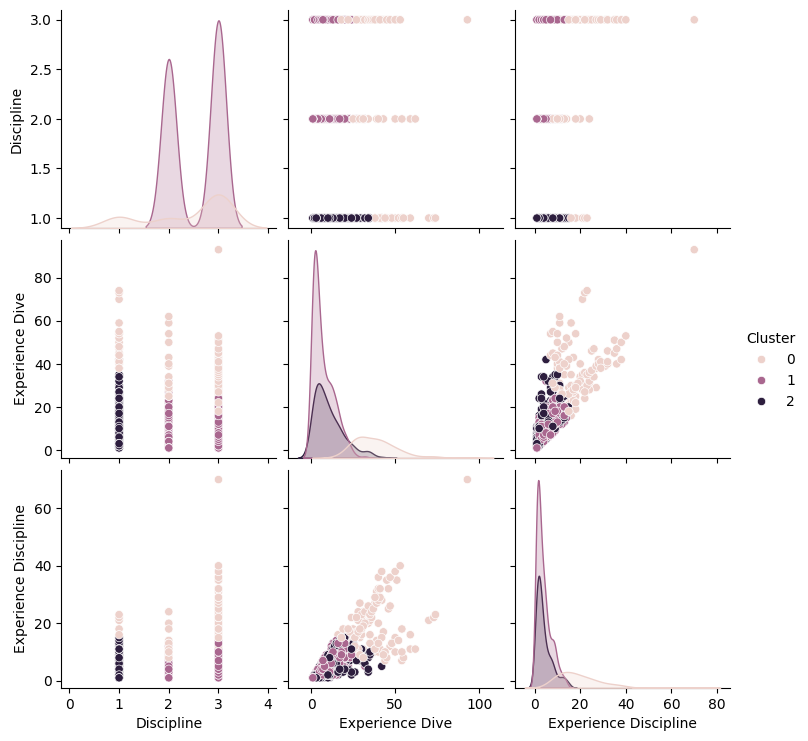

In [26]:
# Pairplot for each cluster
sns.pairplot(red_card_data, hue='Cluster', vars=features)
plt.show()

In [27]:
from sklearn.metrics import silhouette_score
# Calculate silhouette score
silhouette_avg = silhouette_score(X, red_card_data['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.13566556101582544


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the valu

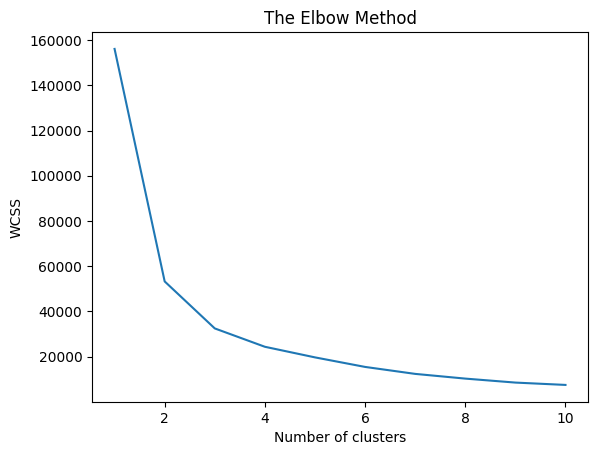

In [28]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [29]:
# Apply KMeans with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_optimal.fit(X)

# Add the optimal cluster labels to your data
red_card_data['Optimal Cluster'] = kmeans_optimal.labels_

# Analyze each cluster
for cluster in sorted(red_card_data['Optimal Cluster'].unique()):
    cluster_data = red_card_data[red_card_data['Optimal Cluster'] == cluster]
    print(f'\nOptimal Cluster {cluster} Analysis:')
    print(cluster_data[features].mean())


Optimal Cluster 0 Analysis:
Discipline               2.039312
Experience Dive          4.911548
Experience Discipline    2.594595
dtype: float64

Optimal Cluster 1 Analysis:
Discipline                2.202899
Experience Dive          44.043478
Experience Discipline    21.043478
dtype: float64

Optimal Cluster 2 Analysis:
Discipline                2.018293
Experience Dive          20.115854
Experience Discipline     9.402439
dtype: float64


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\HP\AppData\Local\Temp\ipykernel_2476\3364869410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  red_card_data['Optimal Cluster'] = kmeans_optimal.labels_


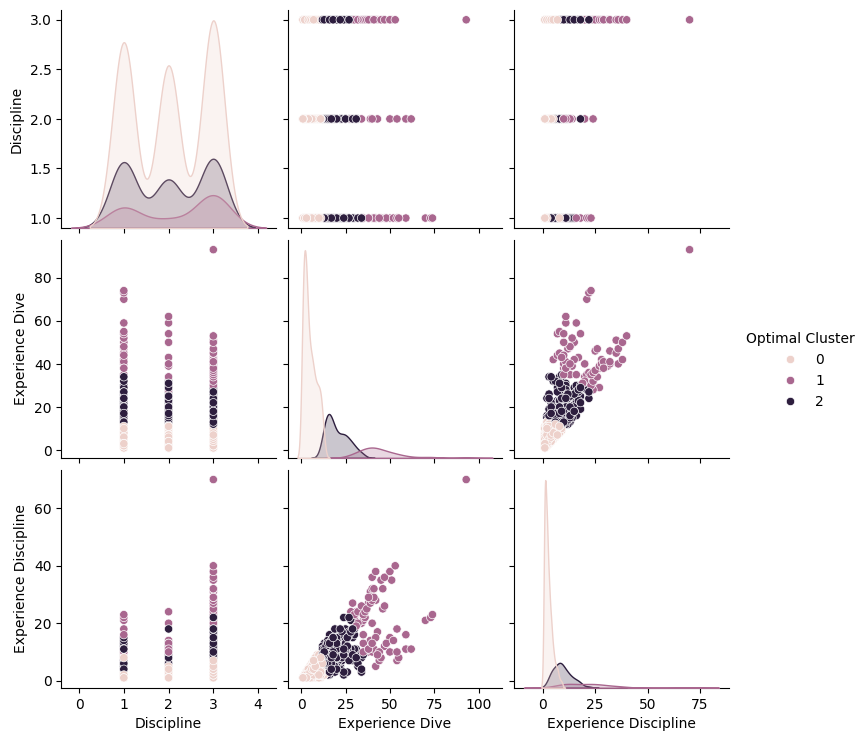

In [30]:
# Pairplot for each optimal cluster
sns.pairplot(red_card_data, hue='Optimal Cluster', vars=features)
plt.show()


In [31]:
# Calculate silhouette score for the optimal clustering
silhouette_optimal = silhouette_score(X, red_card_data['Optimal Cluster'])
print(f'Optimal Silhouette Score: {silhouette_optimal}')


Optimal Silhouette Score: 0.5777995700389017


In [36]:
# Encodage de 'Gender' et 'Event Type'
df=pd.read_csv('Data/AIDA_Results_IA_Institut.csv')
gender_encoder = LabelEncoder()
df['Gender'] = gender_encoder.fit_transform(df['Gender'])

event_type_encoder = LabelEncoder()
df['Event Type'] = event_type_encoder.fit_transform(df['Event Type'])

# Encodage One-Hot pour 'Title Event'
df = pd.get_dummies(df, columns=['Title Event'])

In [41]:
# Séparer les données en ensembles d'entraînement et de test
y_column = 'Title Event_X Głębokościowe Mistrzostwa Polski we Freedivingu | X Polish Depth Championships'  # Remplacez par le nom correct de la colonne


X = df.drop([col for col in df.columns if col.startswith('Title Event')], axis=1)
X = df.drop([col for col in df.columns if col.startswith('Title Event') or col == 'Diver'], axis=1)
diver_encoder = LabelEncoder()
df['Diver'] = diver_encoder.fit_transform(df['Diver'])

X = df.drop([col for col in df.columns if col.startswith('Title Event')], axis=1)

y = df[y_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création et entraînement du modèle
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Évaluation du modèle
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

ValueError: could not convert string to float: 'FIM'

In [38]:
df

,Start,Diver,Gender,Discipline,Line,Official Top,AP,RP,Card,Points,...,Title Event_X Głębokościowe Mistrzostwa Polski we Freedivingu | X Polish Depth Championships,Title Event_XI Głębokościowe Mistrzostwa Polski we Freedivingu,Title Event_Xibalba 2018,Title Event_Xibalba 2019,Title Event_Yum kin AIDA freediving competition,Title Event_depth mini comps,Title Event_little blue hole competition,Title Event_the kaan lum freediving competition,Title Event_winter depth 2017,Title Event_xibalba 2011
0,1,Tasos Grillakis (GRC),1,FIM,NaN,00:00,33,23 m,YELLOW,12.0,...,False,False,False,False,False,False,False,False,False,False
1,2,Antonis Papantonatos (GRC),1,FIM,NaN,00:00,55,47 m,YELLOW,38.0,...,False,False,False,False,False,False,False,False,False,False
2,3,Dimitris Koumoulos (GRC),1,CNF,NaN,00:00,55,55 m,WHITE,55.0,...,False,False,False,False,False,False,False,False,False,False
3,4,Christos Papadopoulos (GRC),1,CWT,NaN,00:00,55,55 m,WHITE,55.0,...,False,False,False,False,False,False,False,False,False,False
4,5,Anna Chalari (GRC),0,CWT,NaN,00:00,15,15 m,WHITE,15.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26836,7,Karine Le Flanchec (FRA),0,CWTB,1.0,09:40,57,57 m,WHITE,57,...,False,False,False,False,False,False,False,False,False,False
26837,8,Anne-Sophie Passalboni (FRA),0,CWT,1.0,09:50,52,52 m,WHITE,52,...,False,False,False,False,False,False,False,False,False,False
26838,9,Clementine Marie (FRA),0,CNF,1.0,10:00,40,40 m,WHITE,40,...,False,False,False,False,False,False,False,False,False,False
26839,10,Eisve Treciakauskaite (LTU),0,CWT,1.0,10:10,33,28 m,YELLOW,22,...,False,False,False,False,False,False,False,False,False,False
